### Data Poisoining

In [ ]:
# Data Overview - Load, PV, Prosumption (MSE, STD) across LL and all Noise Scales


In [ ]:
import pandas as pd
from pathlib import Path

def build_federated_poison_table(root="results2", flatten_columns=False):
    """
    Build a results dataframe for federated energy forecasting poisoning experiments.

    Adds for each (Poisoned/Unpoisoned × Energy) an extra column 'MSE_avg_Diff_%'
    which is the percentual difference of MSE_avg vs the N0.0 reference row:
        diff% = (MSE_avg(row) - MSE_avg(N0.0)) / MSE_avg(N0.0) * 100

    Parameters
    ----------
    root : str or Path
        Folder where the CSV files live (e.g., "results2").
    flatten_columns : bool
        If True, flattens MultiIndex columns to strings "building|energy|metric".

    Returns
    -------
    pandas.DataFrame
        Rows: ["LL", "N0.0", "N0.2", "N0.4", "N0.6", "N0.8", "N1.0"]
        Columns (MultiIndex by default):
            [Poisoned|Unpoisoned] × [Load|PV|Prosumption] ×
            ["MSE_avg","MSE_avg_Diff_%","MSE_bilstm","MSE_softdense","MSE_softlstm"]
        Missing entries are filled with "-".
    """
    root = Path(root)

    noise_rows = ["LL", "N0.0", "N0.2", "N0.4", "N0.6", "N0.8", "N1.0"]
    noise_to_token = {  # maps row label -> filename token
        "N0.0": "0p0",
        "N0.2": "0p2",
        "N0.4": "0p4",
        "N0.6": "0p6",
        "N0.8": "0p8",
        "N1.0": "1p0",
    }

    # Energy types -> filename prefixes
    energy_prefix = {
        "Load": "91Load",
        "PV": "92PV",
        "Prosumption": "93Prosumption",
    }

    def norm_model(arch: str):
        s = str(arch).strip().lower()
        if "bilstm" in s:
            return "bilstm"
        if "softdense" in s:
            return "softdense"
        if "softlstm" in s:
            return "softlstm"
        return None

    # Build MultiIndex columns: put the Diff column right after MSE_avg
    building_sides = ["Poisoned", "Unpoisoned"]
    energies = list(energy_prefix.keys())

    col_tuples = []
    for side in building_sides:
        for en in energies:
            col_tuples.append((side, en, "MSE_avg"))
            col_tuples.append((side, en, "MSE_avg_Diff_%"))
            for m in ["bilstm", "softdense", "softlstm"]:
                col_tuples.append((side, en, f"MSE_{m}"))

    columns = pd.MultiIndex.from_tuples(col_tuples, names=["building", "energy", "metric"])
    out = pd.DataFrame(index=noise_rows, columns=columns, dtype=object)
    out.loc[:, :] = "-"  # default fill

    # Helper to compute per-side metrics from a filtered dataframe (last fed round)
    def compute_side_metrics(df_side: pd.DataFrame):
        per_model = {}
        for m in ["bilstm", "softdense", "softlstm"]:
            vals = df_side.loc[df_side["model"] == m, "mse"]
            per_model[m] = float(vals.mean()) if len(vals) else None
        present = [v for v in per_model.values() if v is not None]
        avg_all = float(sum(present) / len(present)) if present else None
        return avg_all, per_model

    # Fill table from CSVs
    for noise_label in noise_rows:
        if noise_label == "LL":
            continue  # left as "-"
        token = noise_to_token.get(noise_label)
        if token is None:
            continue

        for en, prefix in energy_prefix.items():
            csv_path = root / f"{prefix}_Poison_NoiseScale_{token}_all_results.csv"
            if not csv_path.exists():
                continue

            try:
                df = pd.read_csv(csv_path)
            except Exception:
                continue

            if df.empty or "fed_round" not in df.columns:
                continue

            # Only last federated round
            last_fr = df["fed_round"].max()
            dff = df[df["fed_round"] == last_fr].copy()
            dff["model"] = dff["architecture"].map(norm_model)

            if "poisoned_building" not in dff.columns or "building" not in dff.columns:
                continue

            # Identify poisoned building and its cluster
            pb_rows = dff[dff["building"] == dff["poisoned_building"]]
            if pb_rows.empty:
                pb_val = dff["poisoned_building"].mode().iloc[0]
                cluster_id = (
                    dff.loc[dff["poisoned_building"] == pb_val, "cluster_id"].mode().iloc[0]
                    if "cluster_id" in dff.columns and not dff.empty
                    else None
                )
            else:
                pb_val = pb_rows["poisoned_building"].iloc[0]
                cluster_id = pb_rows["cluster_id"].iloc[0] if "cluster_id" in pb_rows.columns else None

            in_cluster = (dff["cluster_id"] == cluster_id) if (cluster_id is not None and "cluster_id" in dff.columns) else pd.Series(True, index=dff.index)
            poisoned_mask = in_cluster & (dff["building"] == pb_val)
            unpoisoned_mask = in_cluster & (dff["building"] != pb_val)

            poisoned_df = dff.loc[poisoned_mask].copy()
            unpoisoned_df = dff.loc[unpoisoned_mask].copy()

            p_avg, p_models = compute_side_metrics(poisoned_df)
            u_avg, u_models = compute_side_metrics(unpoisoned_df)

            side_to_vals = {
                "Poisoned": (p_avg, p_models),
                "Unpoisoned": (u_avg, u_models),
            }
            for side, (avg_val, model_vals) in side_to_vals.items():
                out.loc[noise_label, (side, en, "MSE_avg")] = avg_val if avg_val is not None else "-"
                for m in ["bilstm", "softdense", "softlstm"]:
                    out.loc[noise_label, (side, en, f"MSE_{m}")] = (
                        model_vals[m] if model_vals.get(m) is not None else "-"
                    )

    # Compute percentage diffs vs N0.0 for each (side, energy) MSE_avg
    for side in building_sides:
        for en in energies:
            ref = out.loc["N0.0", (side, en, "MSE_avg")]
            ref = float(ref) if ref != "-" else None
            for noise_label in noise_rows:
                val = out.loc[noise_label, (side, en, "MSE_avg")]
                v = float(val) if val != "-" else None
                if ref is None or v is None or ref == 0.0:
                    out.loc[noise_label, (side, en, "MSE_avg_Diff_%")] = "-"
                else:
                    out.loc[noise_label, (side, en, "MSE_avg_Diff_%")] = (v - ref) / ref * 100.0

    if flatten_columns:
        out.columns = [f"{lvl0}|{lvl1}|{lvl2}" for (lvl0, lvl1, lvl2) in out.columns.to_list()]

    return out

# Example:
df = build_federated_poison_table(root="results2")
pd.set_option('display.max_columns', None)
display(df)


building  Poisoned                                                       \
energy        Load                                                        
metric     MSE_avg MSE_avg_Diff_% MSE_bilstm MSE_softdense MSE_softlstm   
LL               -              -          -             -            -   
N0.0      0.014868            0.0    0.01387      0.015631     0.015103   
N0.2      0.014827      -0.279715   0.014286      0.015771     0.014422   
N0.4      0.018001      21.071552   0.015931      0.019783      0.01829   
N0.6      0.021396      43.901938   0.018137      0.023645     0.022405   
N0.8      0.024958      67.859527   0.020195      0.028348      0.02633   
N1.0             -              -          -             -            -   

building                                                                 \
energy          PV                                                        
metric     MSE_avg MSE_avg_Diff_% MSE_bilstm MSE_softdense MSE_softlstm   
LL               -              -          -             -            -   
N0.0      0.004129            0.0   0.004071      0.004272     0.004043   
N0.2      0.005669      37.305924   0.005654      0.005694      0.00566   
N0.4      0.008236      99.472408   0.007852      0.008452     0.008403   
N0.6      0.011479     178.027825   0.009812      0.012667     0.011959   
N0.8      0.017938     334.460475   0.011782      0.024823     0.017209   
N1.0             -              -          -             -            -   

building                                                                   \
energy   Prosumption                                                        
metric       MSE_avg MSE_avg_Diff_% MSE_bilstm MSE_softdense MSE_softlstm   
LL                 -              -          -             -            -   
N0.0        0.010231            0.0   0.009806      0.009753     0.011133   
N0.2        0.011136       8.847446   0.010704      0.011734     0.010969   
N0.4        0.015048      47.088227   0.013109      0.016526      0.01551   
N0.6         0.01798      75.748805   0.014287      0.020108     0.019546   
N0.8        0.020192      97.367758   0.015938      0.023483     0.021155   
N1.0               -              -          -             -            -   

building Unpoisoned                                                       \
energy         Load                                                        
metric      MSE_avg MSE_avg_Diff_% MSE_bilstm MSE_softdense MSE_softlstm   
LL                -              -          -             -            -   
N0.0       0.006473            0.0   0.006363      0.006576     0.006479   
N0.2       0.006463      -0.142052   0.006205      0.006593     0.006591   
N0.4       0.006455       -0.26473   0.006309       0.00647     0.006587   
N0.6       0.006813       5.255059   0.006728      0.006916     0.006793   
N0.8       0.006714       3.729452   0.006332      0.006954     0.006856   
N1.0              -              -          -             -            -   

building                                                                 \
energy          PV                                                        
metric     MSE_avg MSE_avg_Diff_% MSE_bilstm MSE_softdense MSE_softlstm   
LL               -              -          -             -            -   
N0.0       0.00403            0.0   0.004038      0.004103     0.003948   
N0.2      0.004073       1.082537   0.004116      0.004067     0.004037   
N0.4      0.004045       0.384964   0.004015      0.004145     0.003976   
N0.6      0.004034       0.097026   0.003979      0.004153     0.003969   
N0.8      0.004077       1.182342   0.004124      0.004095     0.004013   
N1.0             -              -          -             -            -   

building                                                                   
energy   Prosumption                                                       
metric       MSE_avg MSE_avg_Diff_% MSE_bilstm MSE_softdense MS

=== What we ran ===
Experiment(s): FL_GAN_Attack_Demo
Models: BiLSTM, SoftDenseMoE, SoftLSTMMoE
Attack type(s): poison
Attack details (sample): mode=noise, distribution=uniform, scale=0.2
Attack label(s): poison(mode=noise, distribution=uniform, scale=0.2)
Clusters: 2 | Avg cluster size: 2.00 | Total buildings seen: 4
Rounds (replicates): 3 | Fed rounds (communication): 3
Poisoned building per cluster (by design = first in each cluster):
cluster_id  poisoned_building
       C01                  4
       C02                  2

=== Aggregated (overall, by architecture) ===
architecture  mse_mean  mse_std  rmse_mean  rmse_std  mae_mean  mae_std  train_time_mean  train_time_std  avg_epoch_time_mean  avg_epoch_time_std
      BiLSTM  0.015487 0.005872   0.121791  0.025932  0.077295 0.023350        42.954002        3.691470            20.892547            1.810441
SoftDenseMoE  0.013309 0.005898   0.112015  0.027995  0.066787 0.024777         6.118471        0.319288             2.969034    

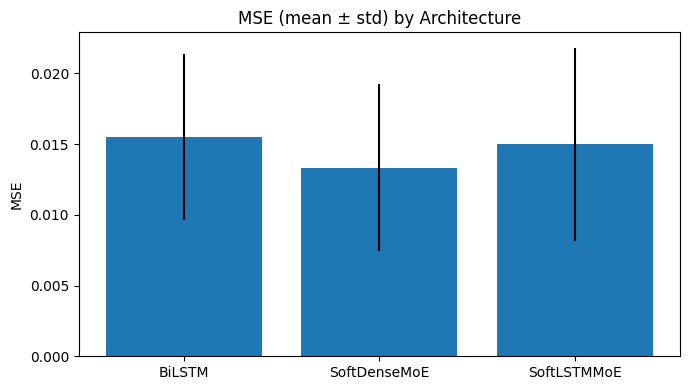

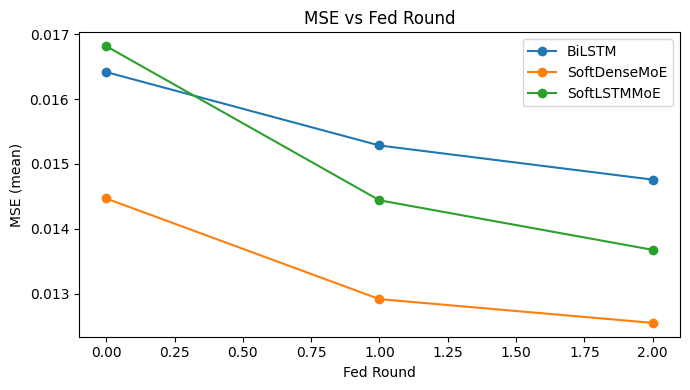

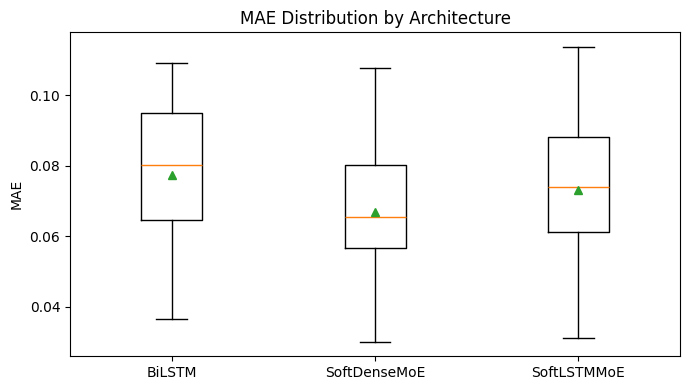

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_fl_results(csv_path, save_figs=True):
    """
    Prints summary ("what we did"), prints aggregated results, and shows plots.
    If per-hour results file exists (for backdoor), it will also summarize and plot per-hour metrics.
    """
    # -----------------------
    # Load main results
    # -----------------------
    df = pd.read_csv(csv_path)
    if df.empty:
        print("No rows in results file.")
        return None

    # Optional figure directory
    fig_dir = os.path.join(os.path.dirname(csv_path), "analysis_figs")
    if save_figs:
        os.makedirs(fig_dir, exist_ok=True)

    # -----------------------
    # 1) Print what we did
    # -----------------------
    exp_names = sorted(df["experiment"].dropna().unique().tolist())
    archs = sorted(df["architecture"].dropna().unique().tolist())
    attacks = sorted(df["attack"].dropna().unique().tolist())
    attack_types = sorted(df["attack_type"].dropna().unique().tolist())
    attack_details = sorted(df["attack_details"].dropna().unique().tolist())

    n_clusters = df["cluster_id"].nunique()
    cluster_sizes = df.groupby("cluster_id")["building"].nunique()
    buildings_total = df["building"].nunique()
    rounds = int(df["round"].max()) + 1 if df["round"].notna().any() else 0
    fed_rounds = int(df["fed_round"].max()) + 1 if df["fed_round"].notna().any() else 0
    poisoned_info = (df[["cluster_id","poisoned_building"]]
                     .drop_duplicates()
                     .sort_values("cluster_id"))
    
    print("=== What we ran ===")
    print(f"Experiment(s): {', '.join(exp_names)}")
    print(f"Models: {', '.join(archs)}")
    print(f"Attack type(s): {', '.join(attack_types) if attack_types else 'n/a'}")
    if attack_details:
        # Keep this readable if many unique combos appear
        shown = attack_details[:5]
        more = f" (+{len(attack_details)-5} more)" if len(attack_details) > 5 else ""
        print(f"Attack details (sample): {', '.join(shown)}{more}")
    print(f"Attack label(s): {', '.join(attacks)}")
    print(f"Clusters: {n_clusters} | Avg cluster size: {cluster_sizes.mean():.2f} | Total buildings seen: {buildings_total}")
    print(f"Rounds (replicates): {rounds} | Fed rounds (communication): {fed_rounds}")
    print("Poisoned building per cluster (by design = first in each cluster):")
    print(poisoned_info.to_string(index=False))
    print()

    # -----------------------
    # 2) Aggregated results
    # -----------------------
    overall = (df.groupby("architecture")
                 .agg(
                     mse_mean=("mse","mean"),
                     mse_std =("mse","std"),
                     rmse_mean=("rmse","mean"),
                     rmse_std =("rmse","std"),
                     mae_mean=("mae","mean"),
                     mae_std =("mae","std"),
                     train_time_mean=("train_time","mean"),
                     train_time_std =("train_time","std"),
                     avg_epoch_time_mean=("avg_time_epoch","mean"),
                     avg_epoch_time_std =("avg_time_epoch","std")
                 )
                 .reset_index())

    print("=== Aggregated (overall, by architecture) ===")
    print(overall.to_string(index=False))
    print()

    # Aggregation: MSE vs Fed round (averaged across users & outer rounds)
    mse_by_fed = (df.groupby(["architecture","fed_round"])["mse"]
                    .mean()
                    .reset_index()
                    .sort_values(["architecture","fed_round"]))

    print("=== MSE by Fed round (mean across users & outer rounds) ===")
    print(mse_by_fed.to_string(index=False))
    print()

    # -----------------------
    # 3) Plots
    # -----------------------
    # 3a) Bar: MSE mean (+/- std) per architecture
    plt.figure(figsize=(7,4))
    x = np.arange(len(overall))
    y = overall["mse_mean"].values
    yerr = overall["mse_std"].values
    plt.bar(x, y, yerr=yerr)
    plt.xticks(x, overall["architecture"].tolist(), rotation=0)
    plt.ylabel("MSE")
    plt.title("MSE (mean ± std) by Architecture")
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(fig_dir, "mse_by_architecture.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 3b) Line: MSE vs Fed round for each architecture
    plt.figure(figsize=(7,4))
    for arch in mse_by_fed["architecture"].unique():
        sub = mse_by_fed[mse_by_fed["architecture"] == arch]
        plt.plot(sub["fed_round"].values, sub["mse"].values, marker="o", label=arch)
    plt.xlabel("Fed Round")
    plt.ylabel("MSE (mean)")
    plt.title("MSE vs Fed Round")
    plt.legend()
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(fig_dir, "mse_vs_fed_round.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 3c) Boxplot: MAE distribution by architecture
    plt.figure(figsize=(7,4))
    data = [df[df["architecture"]==arch]["mae"].values for arch in archs]
    plt.boxplot(data, labels=archs, showmeans=True)
    plt.ylabel("MAE")
    plt.title("MAE Distribution by Architecture")
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(fig_dir, "mae_boxplot_by_architecture.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # -----------------------
    # Optional: Per-hour results (for backdoor runs)
    # -----------------------
    # We look for a sibling per-hour CSV:
    #   ...__ALL_CLUSTERS__per_hour_results.csv
    per_hour_path = csv_path.replace("__all_results.csv", "__per_hour_results.csv").replace("__ALL_CLUSTERS__all_results", "__ALL_CLUSTERS__per_hour_results")
    if os.path.exists(per_hour_path):
        ph = pd.read_csv(per_hour_path)
        if not ph.empty:
            print("=== Per-hour results detected (backdoor) ===")
            # Aggregate per-hour by architecture
            ph_agg = (ph.groupby(["architecture","hour"])
                        .agg(mse_mean=("mse","mean"),
                             mse_std =("mse","std"),
                             rmse_mean=("rmse","mean"),
                             mae_mean=("mae","mean"))
                        .reset_index())
            print(ph_agg.head().to_string(index=False))
            print()

            # Line plot: per-hour MSE (mean) by architecture
            # (one figure, multiple lines)
            plt.figure(figsize=(8,4))
            for arch in ph_agg["architecture"].unique():
                sub = ph_agg[ph_agg["architecture"]==arch].sort_values("hour")
                plt.plot(sub["hour"].values, sub["mse_mean"].values, marker="o", label=arch)
            plt.xlabel("Hour of Day")
            plt.ylabel("MSE (mean)")
            plt.title("Per-hour MSE (mean) by Architecture")
            plt.xticks(range(0,24,2))
            plt.legend()
            plt.tight_layout()
            if save_figs:
                plt.savefig(os.path.join(fig_dir, "per_hour_mse_mean.png"), dpi=150, bbox_inches="tight")
            plt.show()

            # Heatmap-style imshow: hour x architecture (MSE mean)
            # (no seaborn; basic imshow)
            pivot = ph_agg.pivot(index="hour", columns="architecture", values="mse_mean").sort_index()
            plt.figure(figsize=(6,4))
            plt.imshow(pivot.values, aspect="auto")
            plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
            plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=45)
            plt.xlabel("Architecture")
            plt.ylabel("Hour")
            plt.title("Per-hour MSE (mean) — heatmap")
            plt.tight_layout()
            if save_figs:
                plt.savefig(os.path.join(fig_dir, "per_hour_mse_heatmap.png"), dpi=150, bbox_inches="tight")
            plt.show()
        else:
            print("Per-hour file exists but is empty.")
    else:
        # It’s fine—per-hour is only produced for backdoor runs
        pass

    return {
        "overall": overall,
        "mse_by_fed": mse_by_fed
    }

# --- Use it:
csv_path = r"results2\FL_GAN_Attack_Demo__ALL_CLUSTERS__all_results.csv"
summary = analyze_fl_results(csv_path, save_figs=False)



What we ran
Experiment(s): FL_GAN_Attack_Demo
Models: BiLSTM, SoftDenseMoE, SoftLSTMMoE
Attack label(s): poison(mode=noise, distribution=uniform, scale=0.2)
Clusters: 2 | Rounds: 3 | Fed rounds: 3
Comparison mode: WITHIN-RUN poisoned (user1) vs bystanders (non-poisoned)

Within-run: poisoned building vs bystanders (same attacked run)
architecture  is_poisoned_building  mse_mean  mse_std  rmse_mean  mae_mean  n
      BiLSTM                 False  0.014377 0.008189   0.114824  0.073941 18
      BiLSTM                  True  0.016597 0.001148   0.128757  0.080648 18
SoftDenseMoE                 False  0.012738 0.008344   0.106309  0.067597 18
SoftDenseMoE                  True  0.013881 0.001146   0.117721  0.065976 18
 SoftLSTMMoE                 False  0.014659 0.009704   0.113868  0.072491 18
 SoftLSTMMoE                  True  0.015295 0.001241   0.123579  0.073982 18

Effect (MSE):
architecture  mse_clean_like  mse_poisoned    delta       pct
      BiLSTM        0.014377      0.0165

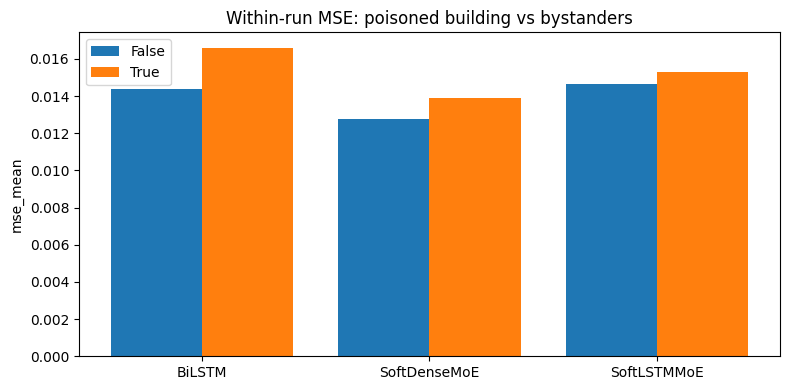

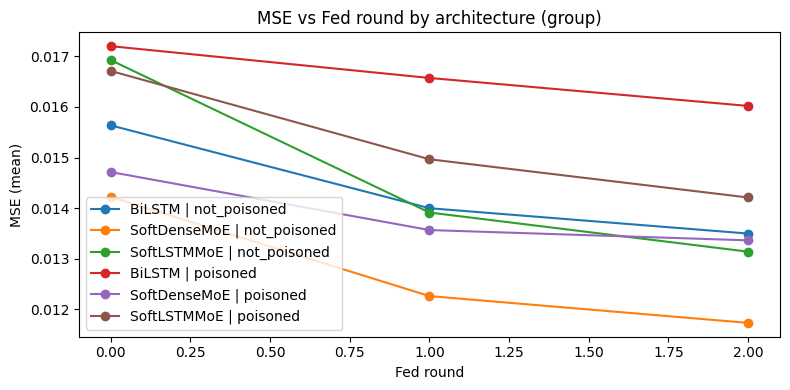

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _safe_mean_std(df, value_col, by):
    agg = (df.groupby(by)[value_col]
             .agg(['mean','std','count'])
             .reset_index()
             .rename(columns={'mean': f'{value_col}_mean', 'std': f'{value_col}_std', 'count': f'{value_col}_n'}))
    return agg

def _print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def _attach_source(df, label):
    df = df.copy()
    df['source'] = label
    return df

def _load_results(csv_path_attack, csv_path_clean=None):
    att = pd.read_csv(csv_path_attack)
    if csv_path_clean and os.path.exists(csv_path_clean):
        cln = pd.read_csv(csv_path_clean)
        return _attach_source(att, 'attack'), _attach_source(cln, 'clean')
    return _attach_source(att, 'attack'), None

def _mark_poisoned_within_run(df):
    """
    Within a single run, rows for the poisoned building are where:
    - attack_type != 'none' AND
    - building == poisoned_building (by design that's user1)
    Everything else in that run is considered 'not_poisoned' (bystanders).
    """
    df = df.copy()
    df['is_poisoned_building'] = (df['attack_type'].fillna('none')!='none') & (df['building']==df['poisoned_building'])
    return df

def _summarize_context(df_attack, df_clean):
    _print_section("What we ran")
    exps = ", ".join(sorted(df_attack['experiment'].dropna().unique()))
    archs = ", ".join(sorted(df_attack['architecture'].dropna().unique()))
    attacks = ", ".join(sorted(df_attack['attack'].dropna().unique()))
    n_clusters = df_attack['cluster_id'].nunique()
    rounds = int(df_attack['round'].max())+1 if df_attack['round'].notna().any() else 0
    freds  = int(df_attack['fed_round'].max())+1 if df_attack['fed_round'].notna().any() else 0

    print(f"Experiment(s): {exps}")
    print(f"Models: {archs}")
    print(f"Attack label(s): {attacks}")
    print(f"Clusters: {n_clusters} | Rounds: {rounds} | Fed rounds: {freds}")
    if df_clean is not None:
        print("Comparison mode: CLEAN (baseline) vs ATTACK (poison/backdoor).")
    else:
        print("Comparison mode: WITHIN-RUN poisoned (user1) vs bystanders (non-poisoned)")

def _aggregate_within_run(df_attack):
    # mark poisoned vs not
    dfw = _mark_poisoned_within_run(df_attack)
    # aggregate by architecture & poisoned flag
    overall = (dfw
               .groupby(['architecture','is_poisoned_building'])
               .agg(mse_mean=('mse','mean'),
                    mse_std =('mse','std'),
                    rmse_mean=('rmse','mean'),
                    mae_mean=('mae','mean'),
                    n=('mse','count'))
               .reset_index())
    # effect (poisoned - not_poisoned) per architecture
    effect = (overall
              .pivot(index='architecture', columns='is_poisoned_building', values='mse_mean')
              .rename(columns={False:'mse_clean_like', True:'mse_poisoned'})
              .assign(delta=lambda d: d['mse_poisoned']-d['mse_clean_like'],
                      pct=lambda d: 100*(d['mse_poisoned']-d['mse_clean_like'])/d['mse_clean_like'])
              .reset_index())
    return dfw, overall, effect

def _aggregate_cross_runs(df_attack, df_clean):
    # compare attack vs clean per architecture
    both = pd.concat([df_attack, df_clean], ignore_index=True)
    overall = (both
               .groupby(['architecture','source'])
               .agg(mse_mean=('mse','mean'),
                    mse_std =('mse','std'),
                    rmse_mean=('rmse','mean'),
                    mae_mean=('mae','mean'),
                    n=('mse','count'))
               .reset_index())

    effect = (overall
              .pivot(index='architecture', columns='source', values='mse_mean')
              .rename(columns={'clean':'mse_clean', 'attack':'mse_attack'})
              .assign(delta=lambda d: d['mse_attack']-d['mse_clean'],
                      pct=lambda d: 100*(d['mse_attack']-d['mse_clean'])/d['mse_clean'])
              .reset_index())
    return both, overall, effect

def _plot_bar_group(df, x_col, y_col, hue_col, title, save_path=None):
    # Simple grouped bar without seaborn
    groups = df[hue_col].unique().tolist()
    cats = df[x_col].unique().tolist()
    idx = np.arange(len(cats))
    width = 0.8 / max(len(groups),1)

    plt.figure(figsize=(8,4))
    for gi, g in enumerate(groups):
        sub = df[df[hue_col]==g].set_index(x_col).reindex(cats)
        plt.bar(idx + gi*width, sub[y_col].values, width=width, label=str(g))
    plt.xticks(idx + (len(groups)-1)*width/2, cats, rotation=0)
    plt.ylabel(y_col)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def _plot_mse_vs_fed(df, group_label, save_path=None):
    plt.figure(figsize=(8,4))
    for grp in sorted(df[group_label].dropna().unique()):
        sub = (df[df[group_label]==grp]
               .groupby(['architecture','fed_round'])['mse']
               .mean().reset_index())
        for arch in sub['architecture'].unique():
            s = sub[sub['architecture']==arch]
            plt.plot(s['fed_round'].values, s['mse'].values, marker='o', label=f"{arch} | {grp}")
    plt.xlabel("Fed round")
    plt.ylabel("MSE (mean)")
    plt.title(f"MSE vs Fed round by architecture ({group_label})")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def _load_per_hour(csv_path_all):
    ph = csv_path_all.replace("__ALL_CLUSTERS__all_results.csv", "__ALL_CLUSTERS__per_hour_results.csv")
    return pd.read_csv(ph) if os.path.exists(ph) else None

def _prep_per_hour_flags(ph_df_attack):
    # in per-hour CSV we kept "user" (e.g., user1). user1 is the poisoned building in each cluster.
    ph = ph_df_attack.copy()
    ph['is_poisoned_building'] = ph['user'].astype(str).str.lower().eq('user1')
    return ph

def analyze_poison_vs_not(
    csv_path_attack,
    csv_path_clean=None,
    save_figs=True
):
    """
    Focused on the effect of poisoned vs not-poisoned.
    - If csv_path_clean is given, compares CLEAN vs ATTACK across runs.
    - Always compares poisoned building (user1) vs others within the ATTACK run.
    - If per-hour files exist (backdoor), computes per-hour gaps too.
    """
    out_dir = os.path.join(os.path.dirname(csv_path_attack), "analysis_poison_vs_not")
    if save_figs:
        os.makedirs(out_dir, exist_ok=True)

    df_attack, df_clean = _load_results(csv_path_attack, csv_path_clean)
    _summarize_context(df_attack, df_clean)

    # -------- within-run (attack): poisoned building vs bystanders
    dfw, within_overall, within_effect = _aggregate_within_run(df_attack)
    _print_section("Within-run: poisoned building vs bystanders (same attacked run)")
    print(within_overall.to_string(index=False))
    print("\nEffect (MSE):")
    print(within_effect.to_string(index=False))

    # plots (within-run)
    _plot_bar_group(
        df=within_overall.rename(columns={'is_poisoned_building':'group'}),
        x_col='architecture', y_col='mse_mean', hue_col='group',
        title='Within-run MSE: poisoned building vs bystanders',
        save_path=os.path.join(out_dir, "within_run_mse_bar.png") if save_figs else None
    )

    _plot_mse_vs_fed(
        df=dfw.assign(group=np.where(dfw['is_poisoned_building'], 'poisoned','not_poisoned')),
        group_label='group',
        save_path=os.path.join(out_dir, "within_run_mse_vs_fed.png") if save_figs else None
    )

    # -------- cross-run (optional): clean vs attack
    if df_clean is not None:
        both, cross_overall, cross_effect = _aggregate_cross_runs(df_attack, df_clean)
        _print_section("Cross-run: CLEAN (baseline) vs ATTACK (all buildings pooled)")
        print(cross_overall.to_string(index=False))
        print("\nEffect (MSE):")
        print(cross_effect.to_string(index=False))

        _plot_bar_group(
            df=cross_overall.rename(columns={'source':'group'}),
            x_col='architecture', y_col='mse_mean', hue_col='group',
            title='Cross-run MSE: CLEAN vs ATTACK',
            save_path=os.path.join(out_dir, "cross_run_mse_bar.png") if save_figs else None
        )

        _plot_mse_vs_fed(
            df=both.rename(columns={'source':'group'}),
            group_label='group',
            save_path=os.path.join(out_dir, "cross_run_mse_vs_fed.png") if save_figs else None
        )

    # -------- per-hour (backdoor runs)
    ph_attack = _load_per_hour(csv_path_attack)
    if ph_attack is not None and not ph_attack.empty:
        _print_section("Per-hour (attack run): poisoned vs bystanders")
        phA = _prep_per_hour_flags(ph_attack)
        # aggregate per-hour by arch & poisoned flag
        phA_overall = (phA
                       .groupby(['architecture','is_poisoned_building','hour'])
                       .agg(mse_mean=('mse','mean'),
                            rmse_mean=('rmse','mean'),
                            mae_mean=('mae','mean'))
                       .reset_index())
        print(phA_overall.head().to_string(index=False))

        # line plot per-hour MSE (poisoned vs not) per architecture
        for arch in phA_overall['architecture'].unique():
            sub = phA_overall[phA_overall['architecture']==arch]
            plt.figure(figsize=(8,4))
            for grp in [False, True]:
                s = sub[sub['is_poisoned_building']==grp].sort_values('hour')
                label = 'poisoned' if grp else 'not_poisoned'
                plt.plot(s['hour'].values, s['mse_mean'].values, marker='o', label=label)
            plt.title(f"Per-hour MSE (attack run) — {arch}")
            plt.xlabel("Hour")
            plt.ylabel("MSE (mean)")
            plt.xticks(range(0,24,2))
            plt.legend()
            plt.tight_layout()
            if save_figs:
                plt.savefig(os.path.join(out_dir, f"per_hour_mse_{arch}.png"), dpi=150, bbox_inches="tight")
            plt.show()

    # If a clean per-hour file exists too, compare clean vs attack per-hour (pooled across users)
    if csv_path_clean:
        ph_clean = _load_per_hour(csv_path_clean)
        if ph_clean is not None and not ph_clean.empty and ph_attack is not None and not ph_attack.empty:
            _print_section("Per-hour (cross-run): CLEAN vs ATTACK (pooled)")
            # mean per-hour per arch
            A = (ph_attack.groupby(['architecture','hour'])['mse'].mean().rename('mse_attack'))
            C = (ph_clean.groupby(['architecture','hour'])['mse'].mean().rename('mse_clean'))
            comp = pd.concat([A,C], axis=1).dropna().reset_index()
            comp['delta'] = comp['mse_attack'] - comp['mse_clean']
            comp['pct'] = 100*comp['delta']/comp['mse_clean']
            print(comp.head().to_string(index=False))

            # plot delta per-hour per arch
            for arch in comp['architecture'].unique():
                s = comp[comp['architecture']==arch].sort_values('hour')
                plt.figure(figsize=(8,3.5))
                plt.plot(s['hour'].values, s['delta'].values, marker='o')
                plt.axhline(0, linestyle='--')
                plt.title(f"Per-hour ΔMSE (ATTACK - CLEAN) — {arch}")
                plt.xlabel("Hour")
                plt.ylabel("ΔMSE")
                plt.xticks(range(0,24,2))
                plt.tight_layout()
                if save_figs:
                    plt.savefig(os.path.join(out_dir, f"per_hour_delta_mse_{arch}.png"), dpi=150, bbox_inches="tight")
                plt.show()

    # Return key tables for further processing
    results = {
        "within_overall": within_overall,
        "within_effect": within_effect
    }
    if df_clean is not None:
        results["cross_overall"] = cross_overall
        results["cross_effect"] = cross_effect
    return results

# ---------------------------
# EXAMPLE USAGE
# ---------------------------
# Single attacked run (your file):
csv_attack = r"results2\FL_GAN_Attack_Demo__ALL_CLUSTERS__all_results.csv"
# Optional: clean baseline file from a run with attack.disabled:
csv_clean  = None  # e.g., r"src\notebooks\results2\FL_BASELINE__ALL_CLUSTERS__all_results.csv"

results = analyze_poison_vs_not(csv_attack, csv_clean, save_figs=False)


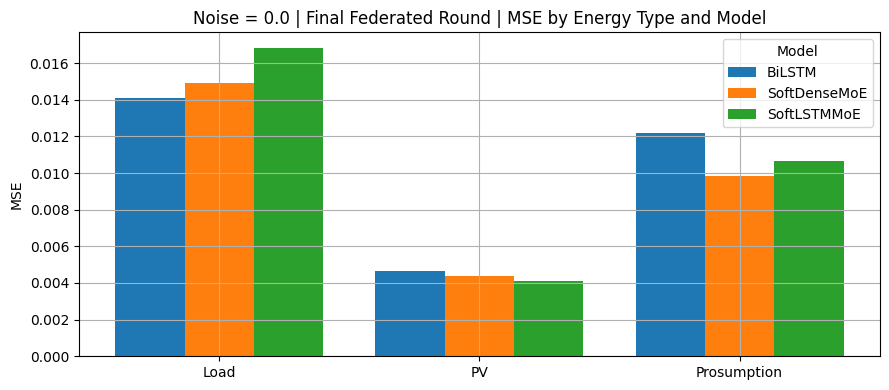

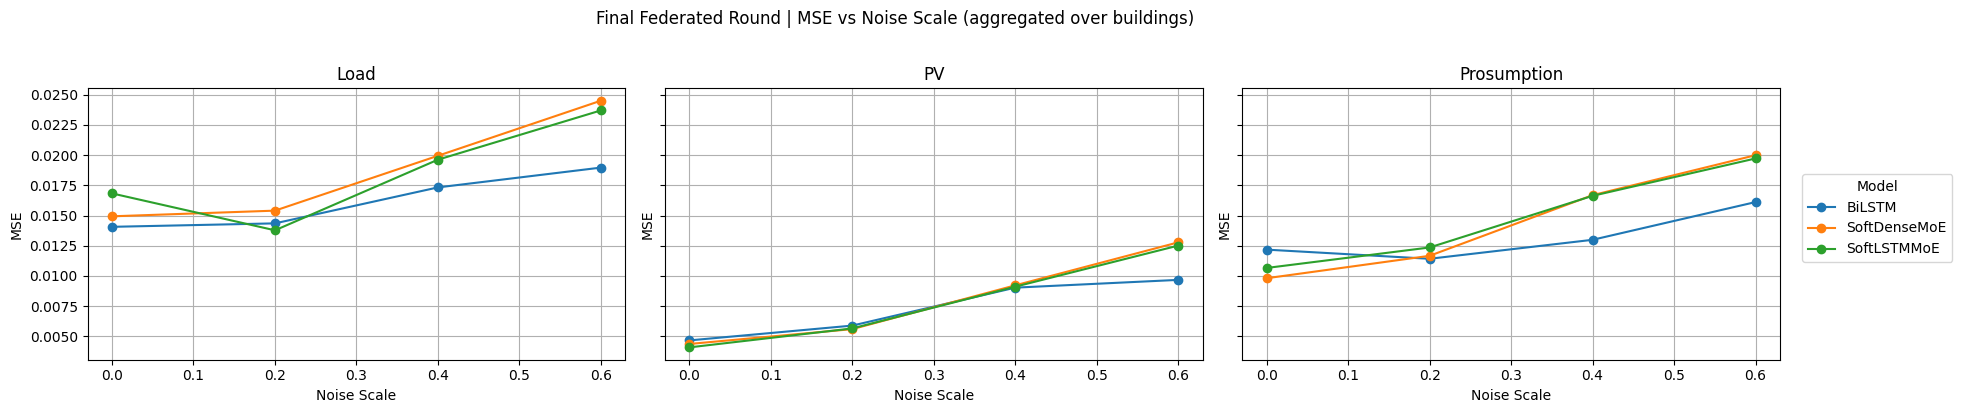

In [12]:
# This cell loads the requested CSVs (if present) and creates the figures you specified.
# Notes:
# - Uses matplotlib only (no seaborn).
# - Due to environment constraints, each chart is rendered in its own figure (no subplots).
# - The code is robust to missing files and prints informative messages.

import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
DATA_DIR = "results2"
ENERGY_FILES = {
    "Load":       ["91Load_Poison_NoiseScale_*_all_results.csv"],
    "PV":         ["92PV_Poison_NoiseScale_*_all_results.csv"],
    "Prosumption":["93Prosumption_Poison_NoiseScale_*_all_results.csv"],
}

# Expected column hints (the code will try to adapt if names differ)
POSSIBLE_COLS = {
    "round":       ["round", "fed_round", "t", "round_idx"],
    "architecture":["architecture", "model", "net", "arch"],
    "building_id": ["building_id", "building", "client_id", "site", "house_id"],
    "mse":         ["mse", "MSE", "metric_value"],
}


def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
        # try case-insensitive match
        for c in df.columns:
            if c.lower() == k.lower():
                return c
    return None


def parse_noise_from_filename(fname):
    # expected "...NoiseScale_0p2_all_results.csv" -> 0.2
    m = re.search(r"NoiseScale_([0-9]+p[0-9]+|[0-9]+(?:\.[0-9]+)?)", fname)
    if not m:
        return None
    token = m.group(1)
    if "p" in token:
        token = token.replace("p", ".")
    try:
        return float(token)
    except:
        return None


def load_energy_type(energy_type, patterns):
    frames = []
    for pat in patterns:
        glob_pat = os.path.join(DATA_DIR, pat)
        for f in glob.glob(glob_pat):
            try:
                df = pd.read_csv(f)
                df["__energy_type__"] = energy_type
                df["__noise_scale__"] = parse_noise_from_filename(os.path.basename(f))
                df["__source_file__"] = os.path.basename(f)
                frames.append(df)
            except Exception as e:
                print(f"[WARN] Failed reading {f}: {e}")
    if frames:
        out = pd.concat(frames, ignore_index=True)
    else:
        out = pd.DataFrame()
    return out


def load_all():
    dfs = [load_energy_type(et, pats) for et, pats in ENERGY_FILES.items()]
    if any([not d.empty for d in dfs]):
        return pd.concat(dfs, ignore_index=True)
    return pd.DataFrame()


def ensure_numeric(s):
    return pd.to_numeric(s, errors="coerce")


def final_round_slice(df):
    rcol = find_col(df, POSSIBLE_COLS["round"]) or "round"
    if rcol not in df.columns:
        return df
    # for each group (energy_type, architecture, noise), take max round rows
    grp = df.groupby(["__energy_type__", "__noise_scale__", find_col(df, POSSIBLE_COLS["architecture"]) or "architecture"])
    idx = grp[rcol].idxmax()
    return df.loc[idx].copy()


# -----------------------------
# Load data
# -----------------------------
df_all = load_all()
if df_all.empty:
    print("[INFO] No result files found under:", os.path.abspath(DATA_DIR))
else:
    # standardize important columns if present
    col_round = find_col(df_all, POSSIBLE_COLS["round"])
    col_model = find_col(df_all, POSSIBLE_COLS["architecture"]) or "architecture"
    col_build = find_col(df_all, POSSIBLE_COLS["building_id"]) or "building_id"
    col_mse   = find_col(df_all, POSSIBLE_COLS["mse"]) or "mse"

    # -----------------------------
    # 1) Bar plot at noise=0.0 for final round: MSE per energy type, bars = models
    # -----------------------------
    df_final = final_round_slice(df_all)
    df0 = df_final[np.isclose(df_final["__noise_scale__"].astype(float), 0.0, equal_nan=False)]
    if df0.empty:
        print("[INFO] No data for noise=0.0 at final round; skipping the first bar plot.")
    else:
        # Aggregate over buildings (mean MSE per energy type and model)
        # If building column not present, this just does a mean over available rows.
        agg = df0.groupby(["__energy_type__", col_model])[col_mse].mean().reset_index()
        # Pivot to models as columns, energy types as rows
        pivot = agg.pivot(index="__energy_type__", columns=col_model, values=col_mse)
        pivot = pivot.apply(ensure_numeric)
        if pivot.dropna(how="all").empty:
            print("[INFO] No numeric MSE data for the first bar plot; skipping.")
        else:
            fig, ax = plt.subplots(figsize=(9, 4))
            # Grouped bar
            x_labels = list(pivot.index)
            positions = np.arange(len(x_labels))
            models = list(pivot.columns)
            width = 0.8 / max(1, len(models))
            for i, m in enumerate(models):
                vals = pivot[m].values
                ax.bar(positions + i*width, vals, width=width, label=str(m))
            ax.set_xticks(positions + width*(len(models)-1)/2)
            ax.set_xticklabels(x_labels)
            ax.set_ylabel("MSE")
            ax.set_title("Noise = 0.0 | Final Federated Round | MSE by Energy Type and Model")
            ax.legend(title="Model")
            plt.tight_layout()
            plt.show()

    # -----------------------------
    # 2) One figure with 3 subplots horizontally:
    #    MSE vs Noise Scale, final round, aggregated over buildings
    # -----------------------------
    energy_types = ["Load", "PV", "Prosumption"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

    for ax, etype in zip(axes, energy_types):
        sub = df_final[df_final["__energy_type__"] == etype]
        if sub.empty:
            ax.set_title(f"{etype} | no data")
            continue

        # mean MSE per noise scale per model
        curves = sub.groupby(["__noise_scale__", col_model])[col_mse].mean().reset_index()
        xs = np.sort(curves["__noise_scale__"].dropna().unique())

        for model, g in curves.groupby(col_model):
            ys = [g[g["__noise_scale__"] == x][col_mse].mean() for x in xs]
            ys = pd.to_numeric(pd.Series(ys), errors="coerce")
            if ys.dropna().empty:
                continue
            ax.plot(xs, ys, marker='o', label=str(model))

        ax.set_title(f"{etype}")
        ax.set_xlabel("Noise Scale")
        ax.set_ylabel("MSE")

    # Put one legend for all subplots (outside the right side)
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Model", loc="center left", bbox_to_anchor=(1, 0.5))
    fig.suptitle("Final Federated Round | MSE vs Noise Scale (aggregated over buildings)", y=1.02)
    plt.tight_layout()
    plt.show()


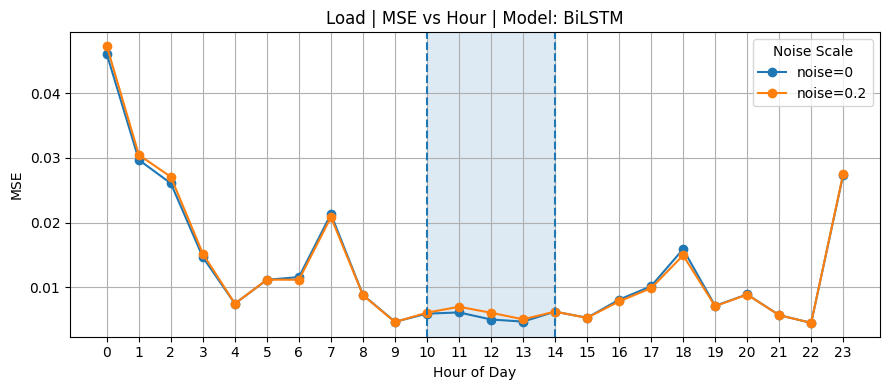

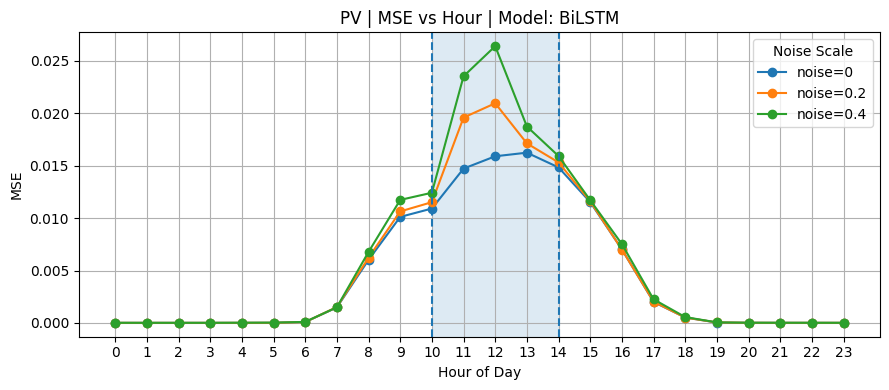

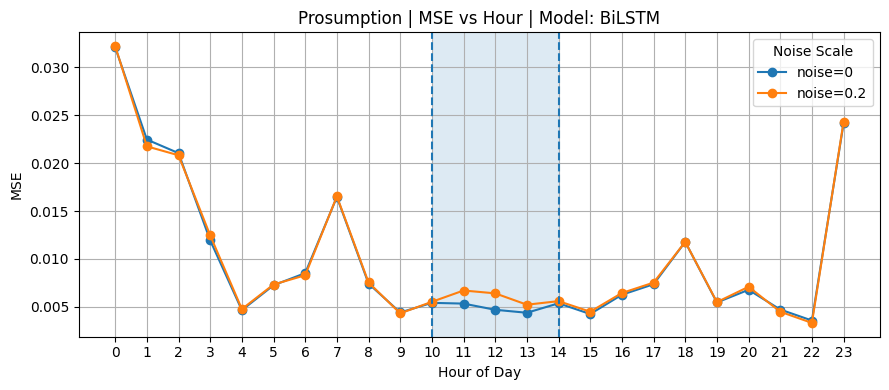

In [13]:
# Plot MSE vs hour for Backdoor attacks, comparing a single selected model across noise scales,
# separately for Load, PV, and Prosumption.
#
# Requirements honored:
# - matplotlib only (no seaborn)
# - One chart per figure (no subplots)
# - No explicit color settings
#
# How to use:
# - Adjust MODEL_SELECT to the model you want to compare across noise scales (e.g., "BiLSTM", "SoftDenseMoE").
# - Adjust SEARCH_DIRS if your CSVs live elsewhere.
# - Adjust ATTACK_START_HOUR and ATTACK_NUM_STEPS to match your experiment.
#
# Expected file patterns (examples):
#   results2/91Load_Backdoor_NoiseScale_0p0_per_hour_results.csv
#   results2/92PV_Backdoor_NoiseScale_0p2_per_hour_results.csv
#   results2/93Prosumption_Backdoor_NoiseScale_0p4_per_hour_results.csv

import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
MODEL_SELECT = "BiLSTM"  # <-- change to your chosen model
SEARCH_DIRS = [
    "results2",
    "src/notebooks/results2",
]
ENERGY_PATTERNS = {
    "Load":        ["91Load_Backdoor_NoiseScale_*_per_hour_results.csv"],
    "PV":          ["92PV_Backdoor_NoiseScale_*_per_hour_results.csv"],
    "Prosumption": ["93Prosumption_Backdoor_NoiseScale_*_per_hour_results.csv"],
}

# Backdoor window to highlight; e.g., start_time="10:30", num_steps=4 -> highlight ~10..14
ATTACK_START_HOUR = 10.5  # 10:30 -> 10.5
ATTACK_NUM_STEPS = 4      # steps (hours)

# -----------------------------
# Utilities
# -----------------------------
def parse_noise_from_filename(fname):
    # Matches ...NoiseScale_0p2_... -> 0.2 ; ...NoiseScale_0.2_... -> 0.2
    m = re.search(r"NoiseScale_([0-9]+p[0-9]+|[0-9]+(?:\.[0-9]+)?)", fname)
    if not m:
        return None
    token = m.group(1).replace("p", ".")
    try:
        return float(token)
    except Exception:
        return None

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None

def load_energy_files(energy_name, patterns, search_dirs):
    frames = []
    for d in search_dirs:
        for pat in patterns:
            full = os.path.join(d, pat)
            for f in glob.glob(full):
                try:
                    df = pd.read_csv(f)
                    df["__energy__"] = energy_name
                    df["__noise__"] = parse_noise_from_filename(os.path.basename(f))
                    df["__file__"] = os.path.basename(f)
                    frames.append(df)
                except Exception as e:
                    print(f"[WARN] Could not read {f}: {e}")
    if frames:
        return pd.concat(frames, ignore_index=True)
    return pd.DataFrame()

def aggregate_per_hour(df, model_col, mse_col, hour_col, model_name):
    """Filter a single model and average MSE per hour & noise scale."""
    if df.empty:
        return pd.DataFrame()
    sub = df[df[model_col] == model_name].copy()
    if sub.empty:
        return pd.DataFrame()
    # Aggregate (mean over buildings/runs) per (hour, noise)
    out = sub.groupby([hour_col, "__noise__"])[mse_col].mean().reset_index()
    out = out.rename(columns={hour_col: "hour", mse_col: "mse"})
    return out

def plot_mse_vs_hour_single(energy_name, dfh, model_name):
    """One figure per energy type; lines = different noise scales."""
    if dfh.empty:
        print(f"[INFO] No data for {energy_name} and model '{model_name}'. Skipping plot.")
        return

    hours = sorted(dfh["hour"].unique())
    noises = sorted(dfh["__noise__"].dropna().unique())

    fig, ax = plt.subplots(figsize=(9, 4))
    for nz in noises:
        g = dfh[dfh["__noise__"] == nz].sort_values("hour")
        if g.empty:
            continue
        ax.plot(g["hour"].values, g["mse"].values, marker='o', label=f"noise={nz:g}")

    # Highlight backdoor window (approximate hour indices)
    start = int(np.floor(ATTACK_START_HOUR))
    end = int(np.floor(ATTACK_START_HOUR + ATTACK_NUM_STEPS))
    ax.axvspan(start, end, alpha=0.15)
    ax.axvline(start, linestyle="--")
    ax.axvline(end, linestyle="--")

    ax.set_title(f"{energy_name} | MSE vs Hour | Model: {model_name}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("MSE")
    ax.set_xticks(range(0, 24, 1))
    ax.legend(title="Noise Scale")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Main: load, aggregate, plot
# -----------------------------
all_frames = []
for energy_name, pats in ENERGY_PATTERNS.items():
    df_e = load_energy_files(energy_name, pats, SEARCH_DIRS)
    if df_e.empty:
        print(f"[INFO] No files found for {energy_name}.")
        continue

    # Resolve column names
    hour_col = find_col(df_e, ["hour"])
    mse_col  = find_col(df_e, ["mse", "MSE"])
    model_col= find_col(df_e, ["architecture", "model", "net", "arch"])

    if hour_col is None or mse_col is None or model_col is None:
        print(f"[INFO] Missing expected columns for {energy_name}; skipping.")
        continue

    df_hourly = aggregate_per_hour(df_e, model_col=model_col, mse_col=mse_col, hour_col=hour_col, model_name=MODEL_SELECT)
    plot_mse_vs_hour_single(energy_name, df_hourly, MODEL_SELECT)


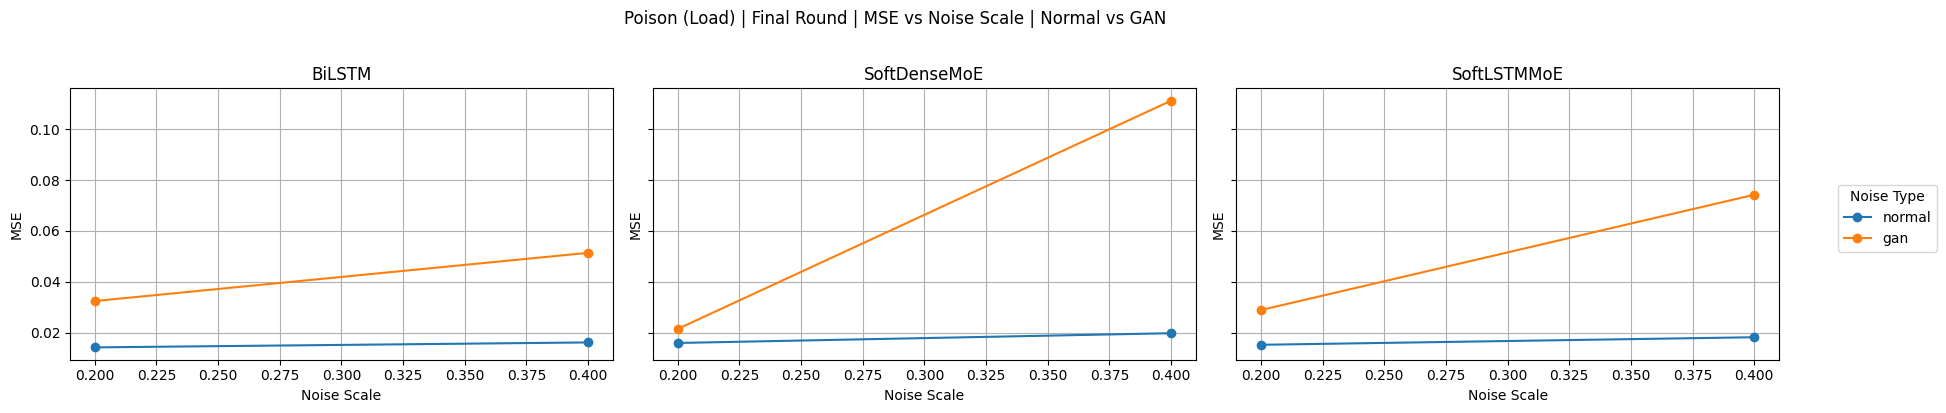

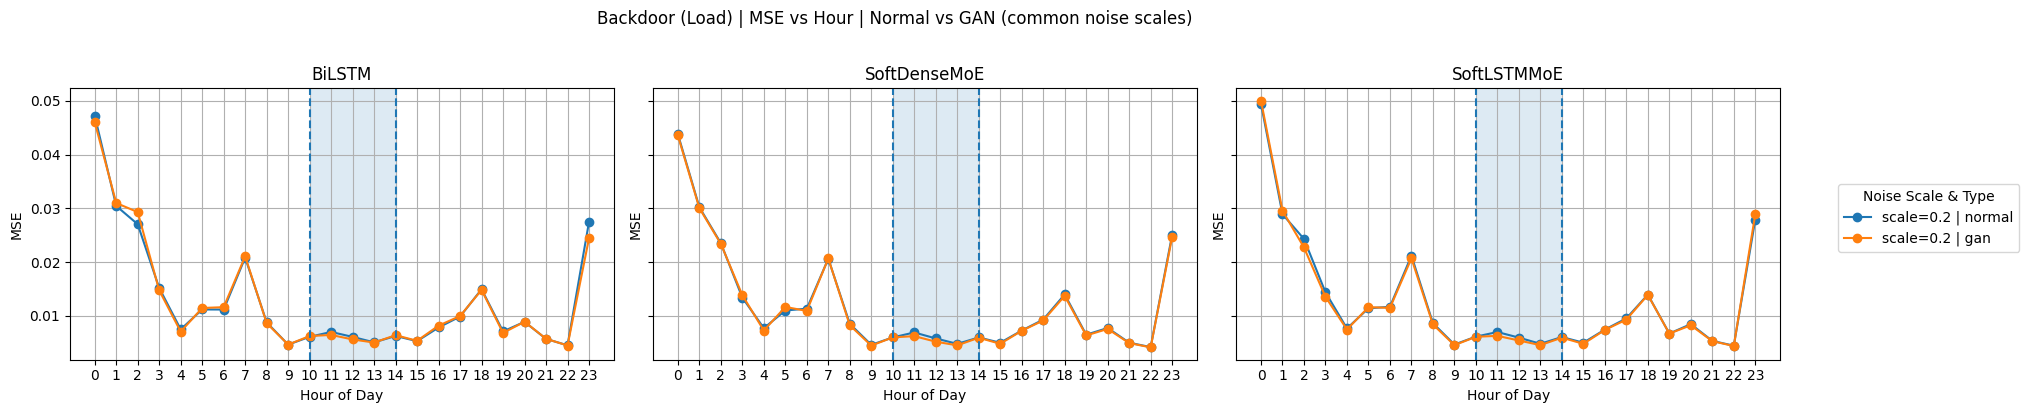

In [17]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
SEARCH_DIRS = ["results2", "src/notebooks/results2"]

# Load only (you said you have GAN vs Normal only for Load)
POISON_NORMAL_PAT = "91Load_Poison_NoiseScale_*_all_results.csv"
POISON_GAN_PAT    = "91Load_Poison_GANScale_*_all_results.csv"

BACKDOOR_NORMAL_PAT = "91Load_Backdoor_NoiseScale_*_per_hour_results.csv"
BACKDOOR_GAN_PAT    = "91Load_Backdoor_GANScale_*_per_hour_results.csv"

# If you want a fixed model order, set this list; otherwise it auto-detects up to 3
ARCH_ORDER = None  # e.g., ["BiLSTM", "SoftDenseMoE", "ThirdModel"]

# Backdoor window (e.g., start_time="10:30", steps=4  -> highlight ~10..14)
ATTACK_START_HOUR = 10.5
ATTACK_NUM_STEPS  = 4

# -----------------------------
# Utilities
# -----------------------------
def parse_scale_from_filename(fname):
    m = re.search(r"(?:NoiseScale|GANScale)_([0-9]+p[0-9]+|[0-9]+(?:\.[0-9]+)?)", fname)
    if not m:
        return None
    token = m.group(1).replace("p", ".")
    try:
        return float(token)
    except Exception:
        return None

def load_files(pattern, label, search_dirs):
    frames = []
    for d in search_dirs:
        for f in glob.glob(os.path.join(d, pattern)):
            try:
                df = pd.read_csv(f)
                df["__label__"] = label  # 'normal' or 'gan'
                df["__scale__"] = parse_scale_from_filename(os.path.basename(f))
                df["__file__"]  = os.path.basename(f)
                frames.append(df)
            except Exception as e:
                print(f"[WARN] Could not read {f}: {e}")
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None

def pick_final_round(df, round_col, group_cols):
    if round_col not in df.columns:
        return df
    idx = df.groupby(group_cols)[round_col].idxmax()
    return df.loc[idx].copy()

def detect_architectures(df, model_col, max_k=3):
    if model_col not in df.columns:
        return []
    freq = df[model_col].value_counts().index.tolist()
    if ARCH_ORDER:
        present = [m for m in ARCH_ORDER if m in freq]
        for m in freq:
            if m not in present:
                present.append(m)
        return present[:max_k]
    return freq[:max_k]

# -----------------------------
# Load POISON (final-round agg): Normal vs GAN
# -----------------------------
pz_normal = load_files(POISON_NORMAL_PAT, "normal", SEARCH_DIRS)
pz_gan    = load_files(POISON_GAN_PAT,    "gan",    SEARCH_DIRS)
pz_all = pd.concat([pz_normal, pz_gan], ignore_index=True) if (not pz_normal.empty or not pz_gan.empty) else pd.DataFrame()

# -----------------------------
# Load BACKDOOR (per-hour): Normal vs GAN
# -----------------------------
bd_normal = load_files(BACKDOOR_NORMAL_PAT, "normal", SEARCH_DIRS)
bd_gan    = load_files(BACKDOOR_GAN_PAT,    "gan",    SEARCH_DIRS)
bd_all = pd.concat([bd_normal, bd_gan], ignore_index=True) if (not bd_normal.empty or not bd_gan.empty) else pd.DataFrame()

# -----------------------------
# Figure 1: POISON — MSE vs Noise Scale (final round), 3 subplots = models
# -----------------------------
if pz_all.empty:
    print("[INFO] Poison: no files found for Load.")
else:
    round_col = find_col(pz_all, ["fed_round","round","t","round_idx"]) or "fed_round"
    mse_col   = find_col(pz_all, ["mse","MSE"]) or "mse"
    model_col = find_col(pz_all, ["architecture","model","net","arch"]) or "architecture"

    # Common scales (present in both normal and GAN). Include 0.0 if available.
    scales_normal = set(pz_all[pz_all["__label__"]=="normal"]["__scale__"].dropna().unique())
    scales_gan    = set(pz_all[pz_all["__label__"]=="gan"]["__scale__"].dropna().unique())
    common_scales = sorted(scales_normal.intersection(scales_gan))
    if not common_scales:
        print("[INFO] Poison: no common scales between normal and GAN; cannot make comparative plot.")
    else:
        # Keep only common scales
        pz_all = pz_all[pz_all["__scale__"].isin(common_scales)].copy()

        # Final round per (scale, label, model)
        try:
            pz_final = pick_final_round(pz_all, round_col, ["__scale__","__label__", model_col])
        except Exception:
            pz_final = pz_all

        # Aggregate (mean) over buildings/runs if multiple rows remain
        agg = pz_final.groupby(["__scale__","__label__", model_col])[mse_col].mean().reset_index()

        # Pick models
        archs = detect_architectures(agg, model_col, max_k=3)
        if not archs:
            print("[INFO] Poison: no architectures detected.")
        else:
            # Create 1x3 subplots
            n_panels = min(3, len(archs))
            fig, axes = plt.subplots(1, n_panels, figsize=(6*n_panels, 4), sharey=True)
            if n_panels == 1:
                axes = [axes]

            for ax, arch in zip(axes, archs):
                sub = agg[agg[model_col] == arch]
                xs = common_scales
                for lab in ["normal","gan"]:
                    ys = []
                    for sc in xs:
                        v = sub[(sub["__label__"]==lab) & (sub["__scale__"]==sc)][mse_col]
                        ys.append(pd.to_numeric(v, errors="coerce").mean() if not v.empty else np.nan)
                    ax.plot(xs, ys, marker='o', label=lab)
                ax.set_title(f"{arch}")
                ax.set_xlabel("Noise Scale")
                ax.set_ylabel("MSE")

            handles, labels = axes[-1].get_legend_handles_labels()
            fig.legend(handles, labels, title="Noise Type", loc="center left", bbox_to_anchor=(1.02, 0.5))
            fig.suptitle("Poison (Load) | Final Round | MSE vs Noise Scale | Normal vs GAN", y=1.02)
            plt.tight_layout()
            plt.show()

# -----------------------------
# Figure 2: BACKDOOR — MSE vs Hour (per-hour), 3 subplots = models
# -----------------------------
if bd_all.empty:
    print("[INFO] Backdoor: no files found for Load.")
else:
    hour_col  = find_col(bd_all, ["hour"]) or "hour"
    mse_col   = find_col(bd_all, ["mse","MSE"]) or "mse"
    model_col = find_col(bd_all, ["architecture","model","net","arch"]) or "architecture"

    # Common scales (present in both normal and GAN). Include 0.0 if available.
    scales_normal = set(bd_all[bd_all["__label__"]=="normal"]["__scale__"].dropna().unique())
    scales_gan    = set(bd_all[bd_all["__label__"]=="gan"]["__scale__"].dropna().unique())
    common_scales = sorted(scales_normal.intersection(scales_gan))
    if not common_scales:
        print("[INFO] Backdoor: no common scales between normal and GAN; cannot make comparative plot.")
    else:
        # Average MSE per hour, per scale, per label, per model
        agg = bd_all.groupby([hour_col, "__scale__", "__label__", model_col])[mse_col].mean().reset_index()

        archs = detect_architectures(agg, model_col, max_k=3)
        if not archs:
            print("[INFO] Backdoor: no architectures detected.")
        else:
            n_panels = min(3, len(archs))
            fig, axes = plt.subplots(1, n_panels, figsize=(6*n_panels, 4), sharey=True)
            if n_panels == 1:
                axes = [axes]

            for ax, arch in zip(axes, archs):
                sub = agg[agg[model_col] == arch]
                for sc in common_scales:
                    for lab in ["normal","gan"]:
                        g = sub[(sub["__scale__"]==sc) & (sub["__label__"]==lab)].sort_values(hour_col)
                        if g.empty:
                            continue
                        ax.plot(g[hour_col].values, g[mse_col].values, marker='o', label=f"scale={sc:g} | {lab}")
                # highlight backdoor window
                start = int(np.floor(ATTACK_START_HOUR))
                end   = int(np.floor(ATTACK_START_HOUR + ATTACK_NUM_STEPS))
                ax.axvspan(start, end, alpha=0.15)
                ax.axvline(start, linestyle='--')
                ax.axvline(end, linestyle='--')

                ax.set_title(f"{arch}")
                ax.set_xlabel("Hour of Day")
                ax.set_xticks(range(0,24,1))
                ax.set_ylabel("MSE")

            handles, labels = axes[-1].get_legend_handles_labels()
            fig.legend(handles, labels, title="Noise Scale & Type", loc="center left", bbox_to_anchor=(1.02, 0.5), ncols=1)
            fig.suptitle("Backdoor (Load) | MSE vs Hour | Normal vs GAN (common noise scales)", y=1.02)
            plt.tight_layout()
            plt.show()
